In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [2]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [3]:
data = pd.read_json(DATA_DIR + "data.1.json", lines=True)

In [4]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [5]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

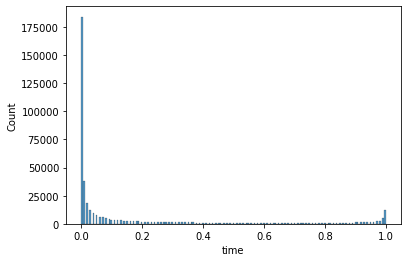

In [6]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [7]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(343880, 42527, 42715)

In [8]:
features = ["start", "track"]

In [9]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(50000, embedding_dim)
        self.track = nn.Embedding(50000, embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0])
        track = self.track(x[:, 1])
        return torch.sum(context * track, dim=1)
            
    
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [10]:
train_dataset = td.TensorDataset(
    torch.from_numpy(train_data[features].values), 
    torch.from_numpy(train_data["time"].values)
)

val_dataset = td.TensorDataset(
    torch.from_numpy(val_data[features].values), 
    torch.from_numpy(val_data["time"].values)
)

In [11]:
net = ContextualRanker()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    gpus=0, 
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(
    net, 
    td.DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=0),
    td.DataLoader(val_dataset, batch_size=2048, num_workers=0)
)


  | Name    | Type      | Params
--------------------------------------
0 | context | Embedding | 500 K 
1 | track   | Embedding | 500 K 
--------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.000     Total estimated model params size (MB)


/Users/n.anokhin/Projects/virtualenv/recsys-course-itmo-2022/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/n.anokhin/Projects/virtualenv/recsys-course-itmo-2022/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Epoch 0:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 168/189 [00:03<00:00, 53.04it/s, loss=8.9, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 1:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 168/189 [00:03<00:00, 52.03it/s, loss=8.18, v_num=7, val_loss=8.910]
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 168/189 [00:03<00:00, 51.84it/s, loss=7.38, v_num=7, val_loss=8.280]
Validating: 0it [00:00, ?it/s]
Epoch 3:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 168/189 [00:03<00:00, 51.32it/s, loss=6.71, v_num=7, val_loss=7.710]
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|██████████████████████████████████████████

In [19]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path)

In [20]:
test_loader = td.DataLoader(torch.from_numpy(test_data[features].values), batch_size=512, shuffle=False, num_workers=0)

nn_predictions = []
for batch in tqdm.tqdm(test_loader, total=test_data.shape[0] / 512):
    nn_predictions.extend(best(batch).detach().numpy().tolist())

84it [00:00, 992.24it/s]                                                                                                                                                                                    


In [21]:
eval_data = test_data.copy().assign(nn = nn_predictions).assign(rdm = np.random.random(len(test_data))).assign(avg = train_data["time"].mean()).head()

In [22]:
sm.mean_squared_error(eval_data["nn"], eval_data["time"])

0.003842201321409147

In [23]:
sm.mean_squared_error(eval_data["rdm"], eval_data["time"])

0.39510647045558805

In [24]:
sm.mean_squared_error(eval_data["avg"], eval_data["time"])

0.029200314217158296

## Compute top recommendations

In [25]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)

In [26]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [27]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [28]:
k = 10
with open(DATA_DIR + "tracks_recs.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

50000it [01:28, 566.98it/s]


In [39]:
track = 1982
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

,artist,title
1982,Rammstein,Engel


In [40]:
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]

,artist,title
5469,Black Eyed Peas,Shut Up
5546,No Doubt,Don't Speak
10782,Susan Tedeschi,Soul Of A Man
11340,Uffie,Pop The Glock
14378,Petey Pablo,Didn't I
15466,In Flames,Zombie Inc.
21869,Fall Out Boy,I've Got A Dark Alley And A Bad Idea That Says...
36756,Carrie Underwood,Wheel Of The World
41203,Alex Ubago,Cuanto antes
49445,mewithoutYou,Goodbye_ I!
